# Reflect stats

In [1]:
import pandas as pd

In [2]:
df = pd.read_json("results.json", lines=True)
df = df[["puzzle", "name", "device", "timestamp"]]
df

,puzzle,name,device,timestamp
0,2023-04-22,preload,f5ac725c-8460-4856-aa49-8de747b24919,2023-04-23 06:17:45.388
1,2023-04-15,preload,242ce71b-373e-424d-b6e5-cb7eb32455e7,2023-04-15 14:12:14.261
2,2023-04-16,preload,c583d3ab-1a30-4aa8-b82a-1e9727817695,2023-04-17 04:42:02.530
3,2023-04-16,preload,203fee6d-552b-4ab6-a55c-8f66a01edb70,2023-04-16 12:31:19.009
4,2023-04-16,preload,49481d0d-347b-4158-a65d-dfdf7d4ebfe7,2023-04-16 19:25:15.144
...,...,...,...,...
573,2023-04-24,firstMove,fcca204e-08a1-4efd-9a84-658bfb08f211,2023-04-24 19:09:03.037
574,2023-04-24,firstMove,fcca204e-08a1-4efd-9a84-658bfb08f211,2023-04-24 19:08:27.692
575,2023-04-16,solved,ff0cb9bb-9bc6-4087-9f2c-64083070706c,2023-04-16 19:31:42.507
576,2023-04-16,preload,ff0cb9bb-9bc6-4087-9f2c-64083070706c,2023-04-16 19:30:33.939


Number of players per day

In [3]:
df_players = df.groupby("puzzle").agg("nunique").rename(columns={"device": "n_players"})
df_players = df_players[["n_players"]]
df_players

,n_players
puzzle,
2023-04-15,11
2023-04-16,23
2023-04-17,15
2023-04-18,11
2023-04-19,11
2023-04-20,11
2023-04-21,12
2023-04-22,17
2023-04-23,17


Number started per day

In [4]:
df_started = df[df["name"] == "firstMove"]
df_started = df_started.groupby("puzzle").agg("nunique").rename(columns={"device": "n_started"})
df_started = df_started[["n_started"]]
df_started

,n_started
puzzle,
2023-04-15,10
2023-04-16,18
2023-04-17,13
2023-04-18,11
2023-04-19,10
2023-04-20,11
2023-04-21,12
2023-04-22,16
2023-04-23,17


Number solved per day

In [5]:
df_solved = df[df["name"] == "solved"]
df_solved = df_solved.groupby("puzzle").agg("nunique").rename(columns={"device": "n_solved"})
df_solved = df_solved[["n_solved"]]
df_solved

,n_solved
puzzle,
2023-04-15,6
2023-04-16,14
2023-04-17,7
2023-04-18,11
2023-04-19,9
2023-04-20,11
2023-04-21,11
2023-04-22,12
2023-04-23,15


In [6]:
df_stats = pd.merge(df_players, df_started, on="puzzle")
df_stats = pd.merge(df_stats, df_solved, on="puzzle")
df_stats

,n_players,n_started,n_solved
puzzle,,,
2023-04-15,11,10,6
2023-04-16,23,18,14
2023-04-17,15,13,7
2023-04-18,11,11,11
2023-04-19,11,10,9
2023-04-20,11,11,11
2023-04-21,12,12,11
2023-04-22,17,16,12
2023-04-23,17,17,15


In [7]:
df_stats["success"] = 100 * df_stats["n_solved"] / df_stats["n_started"]
df_stats["failure"] = 100 - df_stats["success"]
df_stats

,n_players,n_started,n_solved,success,failure
puzzle,,,,,
2023-04-15,11,10,6,60.000000,40.000000
2023-04-16,23,18,14,77.777778,22.222222
2023-04-17,15,13,7,53.846154,46.153846
2023-04-18,11,11,11,100.000000,0.000000
2023-04-19,11,10,9,90.000000,10.000000
2023-04-20,11,11,11,100.000000,0.000000
2023-04-21,12,12,11,91.666667,8.333333
2023-04-22,17,16,12,75.000000,25.000000
2023-04-23,17,17,15,88.235294,11.764706


In [8]:
import math 
grouped = df.groupby(["puzzle", "device"])

def compute_solve_duration(group):
    """The time between the last 'first move' event before the first 'solved' event, and that 'solved' event."""
    
    events = group["name"].tolist()
    if "solved" not in events:
        return math.nan # wasn't solved
    
    # filter out preload events, and sort by timestamp
    group_playing = group[group["name"] != "preload"].sort_values(by=["timestamp"])
    
    last_first_move_time_before_solved = math.nan
    first_solve_time = math.nan
    for index, row in group_playing.iterrows():
        if row["name"] == "firstMove":
            last_first_move_time_before_solved = row["timestamp"]
        elif row["name"] == "solved":
            first_solve_time = row["timestamp"]
            break # ignore any more events (e.g. if solved again)
    return first_solve_time - last_first_move_time_before_solved

df_solve_durations = grouped.apply(compute_solve_duration)
df_solve_durations = df_solve_durations.reset_index(name="solve_duration")
df_solve_durations

,puzzle,device,solve_duration
0,2023-04-15,19e4e3c4-26e5-4fa5-a70d-2e05580d85f2,0 days 00:01:26.387000
1,2023-04-15,242ce71b-373e-424d-b6e5-cb7eb32455e7,NaT
2,2023-04-15,280ae5cd-f26f-4cca-af23-069d3f289b0b,0 days 01:04:52.549000
3,2023-04-15,532623db-b310-48bb-ad25-b5908efec959,0 days 00:03:16.170000
4,2023-04-15,6ffea007-dc05-48c7-8423-203379196209,0 days 00:04:26.418000
...,...,...,...
158,2023-04-25,73336db2-2a14-450e-93cc-7646a43b0abc,NaT
159,2023-04-25,75defe7f-0914-4b5b-a75a-2e72d58ed6c3,0 days 00:01:47.380000
160,2023-04-25,aaf4da14-d237-40b8-9202-092b0237a030,0 days 00:01:52.855000
161,2023-04-25,b644f0ec-b5f0-4a0e-a08f-cd72b623d30f,0 days 00:00:26.228000


In [9]:
df_solve_durations = df_solve_durations[df_solve_durations["solve_duration"].notnull()]
df_solve_duration_stats = df_solve_durations.groupby("puzzle")["solve_duration"].median()
df_solve_duration_stats = df_solve_duration_stats.reset_index(name="median_solve_duration")
df_solve_duration_stats

,puzzle,median_solve_duration
0,2023-04-15,0 days 00:02:41.129500
1,2023-04-16,0 days 00:01:11.756500
2,2023-04-17,0 days 00:07:14.173000
3,2023-04-18,0 days 00:03:31.709000
4,2023-04-19,0 days 00:00:58.333000
5,2023-04-20,0 days 00:01:47.471000
6,2023-04-21,0 days 00:05:09.015000
7,2023-04-22,0 days 00:01:18.721500
8,2023-04-23,0 days 00:02:29.962000
9,2023-04-24,0 days 00:01:55.421500


In [10]:
df_stats = pd.merge(df_stats, df_solve_duration_stats, on="puzzle")
df_stats

,puzzle,n_players,n_started,n_solved,success,failure,median_solve_duration
0,2023-04-15,11,10,6,60.000000,40.000000,0 days 00:02:41.129500
1,2023-04-16,23,18,14,77.777778,22.222222,0 days 00:01:11.756500
2,2023-04-17,15,13,7,53.846154,46.153846,0 days 00:07:14.173000
3,2023-04-18,11,11,11,100.000000,0.000000,0 days 00:03:31.709000
4,2023-04-19,11,10,9,90.000000,10.000000,0 days 00:00:58.333000
5,2023-04-20,11,11,11,100.000000,0.000000,0 days 00:01:47.471000
6,2023-04-21,12,12,11,91.666667,8.333333,0 days 00:05:09.015000
7,2023-04-22,17,16,12,75.000000,25.000000,0 days 00:01:18.721500
8,2023-04-23,17,17,15,88.235294,11.764706,0 days 00:02:29.962000
9,2023-04-24,25,24,22,91.666667,8.333333,0 days 00:01:55.421500


## Graphs

<Axes: xlabel='puzzle', ylabel='median_solve_duration_s'>

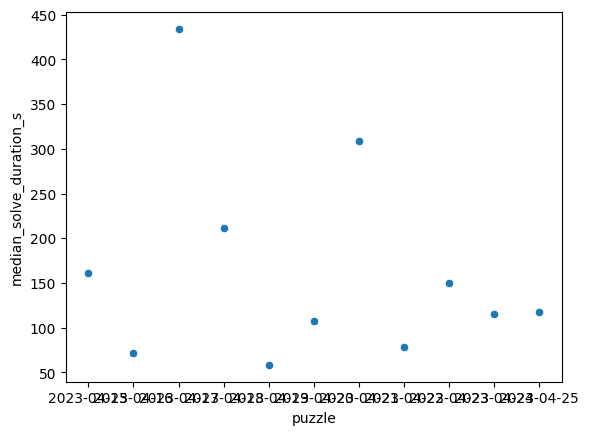

In [11]:
import seaborn as sns
df_stats["median_solve_duration_s"] = df_stats["median_solve_duration"].dt.total_seconds()
sns.scatterplot(data=df_stats, x="puzzle", y="median_solve_duration_s")

/var/folders/jz/_qsj6p5j2gg4s064yzhrbtcw0000gn/T/ipykernel_20648/1514075472.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_solve_durations["solve_duration_s"] = df_solve_durations["solve_duration"].dt.total_seconds()


<Axes: xlabel='puzzle', ylabel='solve_duration_s'>

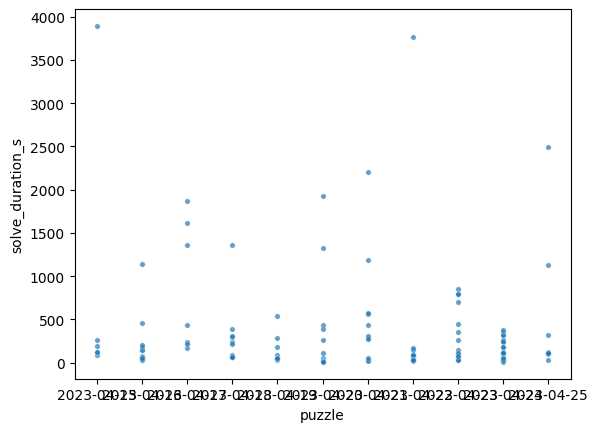

In [12]:
df_solve_durations["solve_duration_s"] = df_solve_durations["solve_duration"].dt.total_seconds()
sns.scatterplot(data=df_solve_durations, x="puzzle", y="solve_duration_s", s=15, alpha=0.7)

<Axes: xlabel='puzzle', ylabel='failure'>

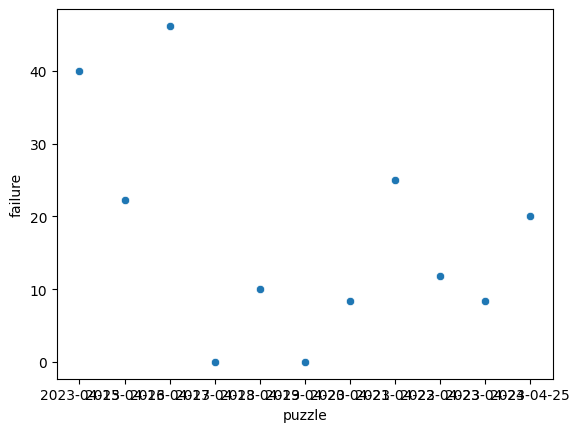

In [13]:
sns.scatterplot(data=df_stats, x="puzzle", y="failure")

## Feature analysis

Let's load features and see how they correlate with difficulty (as measured by `mean_solve_duration`)

In [14]:
features = pd.read_csv("features.csv")
features[['puzzle']] = features.filename.str.extract(r'puzzle-(.+).txt', expand=True)
features

,filename,difficulty,num_blocks,num_mirror_balls,num_beams,mean_blocks_per_beam,max_blocks_per_beam,mean_beams_per_block,max_beams_per_block,mean_beam_distance,max_beam_distance,num_zero_reflection_blocks,puzzle
0,puzzle-2023-03-31.txt,4,5,1,6,1.333333,3,1.600000,2,4.500000,10,0,2023-03-31
1,puzzle-2023-04-01.txt,2,4,1,5,1.400000,3,1.750000,3,4.600000,8,0,2023-04-01
2,puzzle-2023-04-02.txt,3,6,0,4,1.750000,2,1.166667,2,6.250000,11,0,2023-04-02
3,puzzle-2023-04-03.txt,2,3,0,4,1.000000,3,1.333333,2,5.500000,8,0,2023-04-03
4,puzzle-2023-04-04.txt,2,4,0,3,1.666667,2,1.250000,2,5.000000,8,0,2023-04-04
5,puzzle-2023-04-05.txt,3,4,0,4,1.500000,4,1.500000,2,6.000000,10,0,2023-04-05
6,puzzle-2023-04-06.txt,3,5,0,4,1.750000,2,1.400000,2,6.250000,8,0,2023-04-06
7,puzzle-2023-04-07.txt,2,5,0,5,1.400000,2,1.400000,2,5.200000,7,0,2023-04-07
8,puzzle-2023-04-08.txt,3,5,0,4,1.250000,2,1.250000,2,6.000000,7,1,2023-04-08
9,puzzle-2023-04-09.txt,3,3,1,4,2.000000,3,2.666667,3,5.250000,6,0,2023-04-09


In [15]:
df_all = pd.merge(df_stats, features, on="puzzle")
df_all

,puzzle,n_players,n_started,n_solved,success,failure,median_solve_duration,median_solve_duration_s,filename,difficulty,num_blocks,num_mirror_balls,num_beams,mean_blocks_per_beam,max_blocks_per_beam,mean_beams_per_block,max_beams_per_block,mean_beam_distance,max_beam_distance,num_zero_reflection_blocks
0,2023-04-15,11,10,6,60.000000,40.000000,0 days 00:02:41.129500,161.1295,puzzle-2023-04-15.txt,4,5,1,6,1.166667,3,1.400000,2,5.500000,10,0
1,2023-04-16,23,18,14,77.777778,22.222222,0 days 00:01:11.756500,71.7565,puzzle-2023-04-16.txt,4,6,1,6,1.666667,3,1.666667,2,5.166667,9,0
2,2023-04-17,15,13,7,53.846154,46.153846,0 days 00:07:14.173000,434.1730,puzzle-2023-04-17.txt,4,7,0,5,2.200000,6,1.571429,2,6.000000,8,0
3,2023-04-18,11,11,11,100.000000,0.000000,0 days 00:03:31.709000,211.7090,puzzle-2023-04-18.txt,4,6,1,7,2.000000,5,2.333333,4,5.571429,10,0
4,2023-04-19,11,10,9,90.000000,10.000000,0 days 00:00:58.333000,58.3330,puzzle-2023-04-19.txt,4,6,1,6,2.000000,5,2.000000,3,6.333333,8,0
5,2023-04-20,11,11,11,100.000000,0.000000,0 days 00:01:47.471000,107.4710,puzzle-2023-04-20.txt,4,4,0,4,1.500000,4,1.500000,2,6.500000,12,0
6,2023-04-21,12,12,11,91.666667,8.333333,0 days 00:05:09.015000,309.0150,puzzle-2023-04-21.txt,3,5,1,6,2.166667,7,2.600000,3,6.500000,14,0
7,2023-04-22,17,16,12,75.000000,25.000000,0 days 00:01:18.721500,78.7215,puzzle-2023-04-22.txt,4,6,0,6,1.666667,4,1.666667,2,5.666667,11,0
8,2023-04-23,17,17,15,88.235294,11.764706,0 days 00:02:29.962000,149.9620,puzzle-2023-04-23.txt,4,5,1,7,1.857143,5,2.600000,4,6.000000,10,0
9,2023-04-24,25,24,22,91.666667,8.333333,0 days 00:01:55.421500,115.4215,puzzle-2023-04-24.txt,4,5,1,5,1.800000,3,1.800000,3,5.600000,8,0


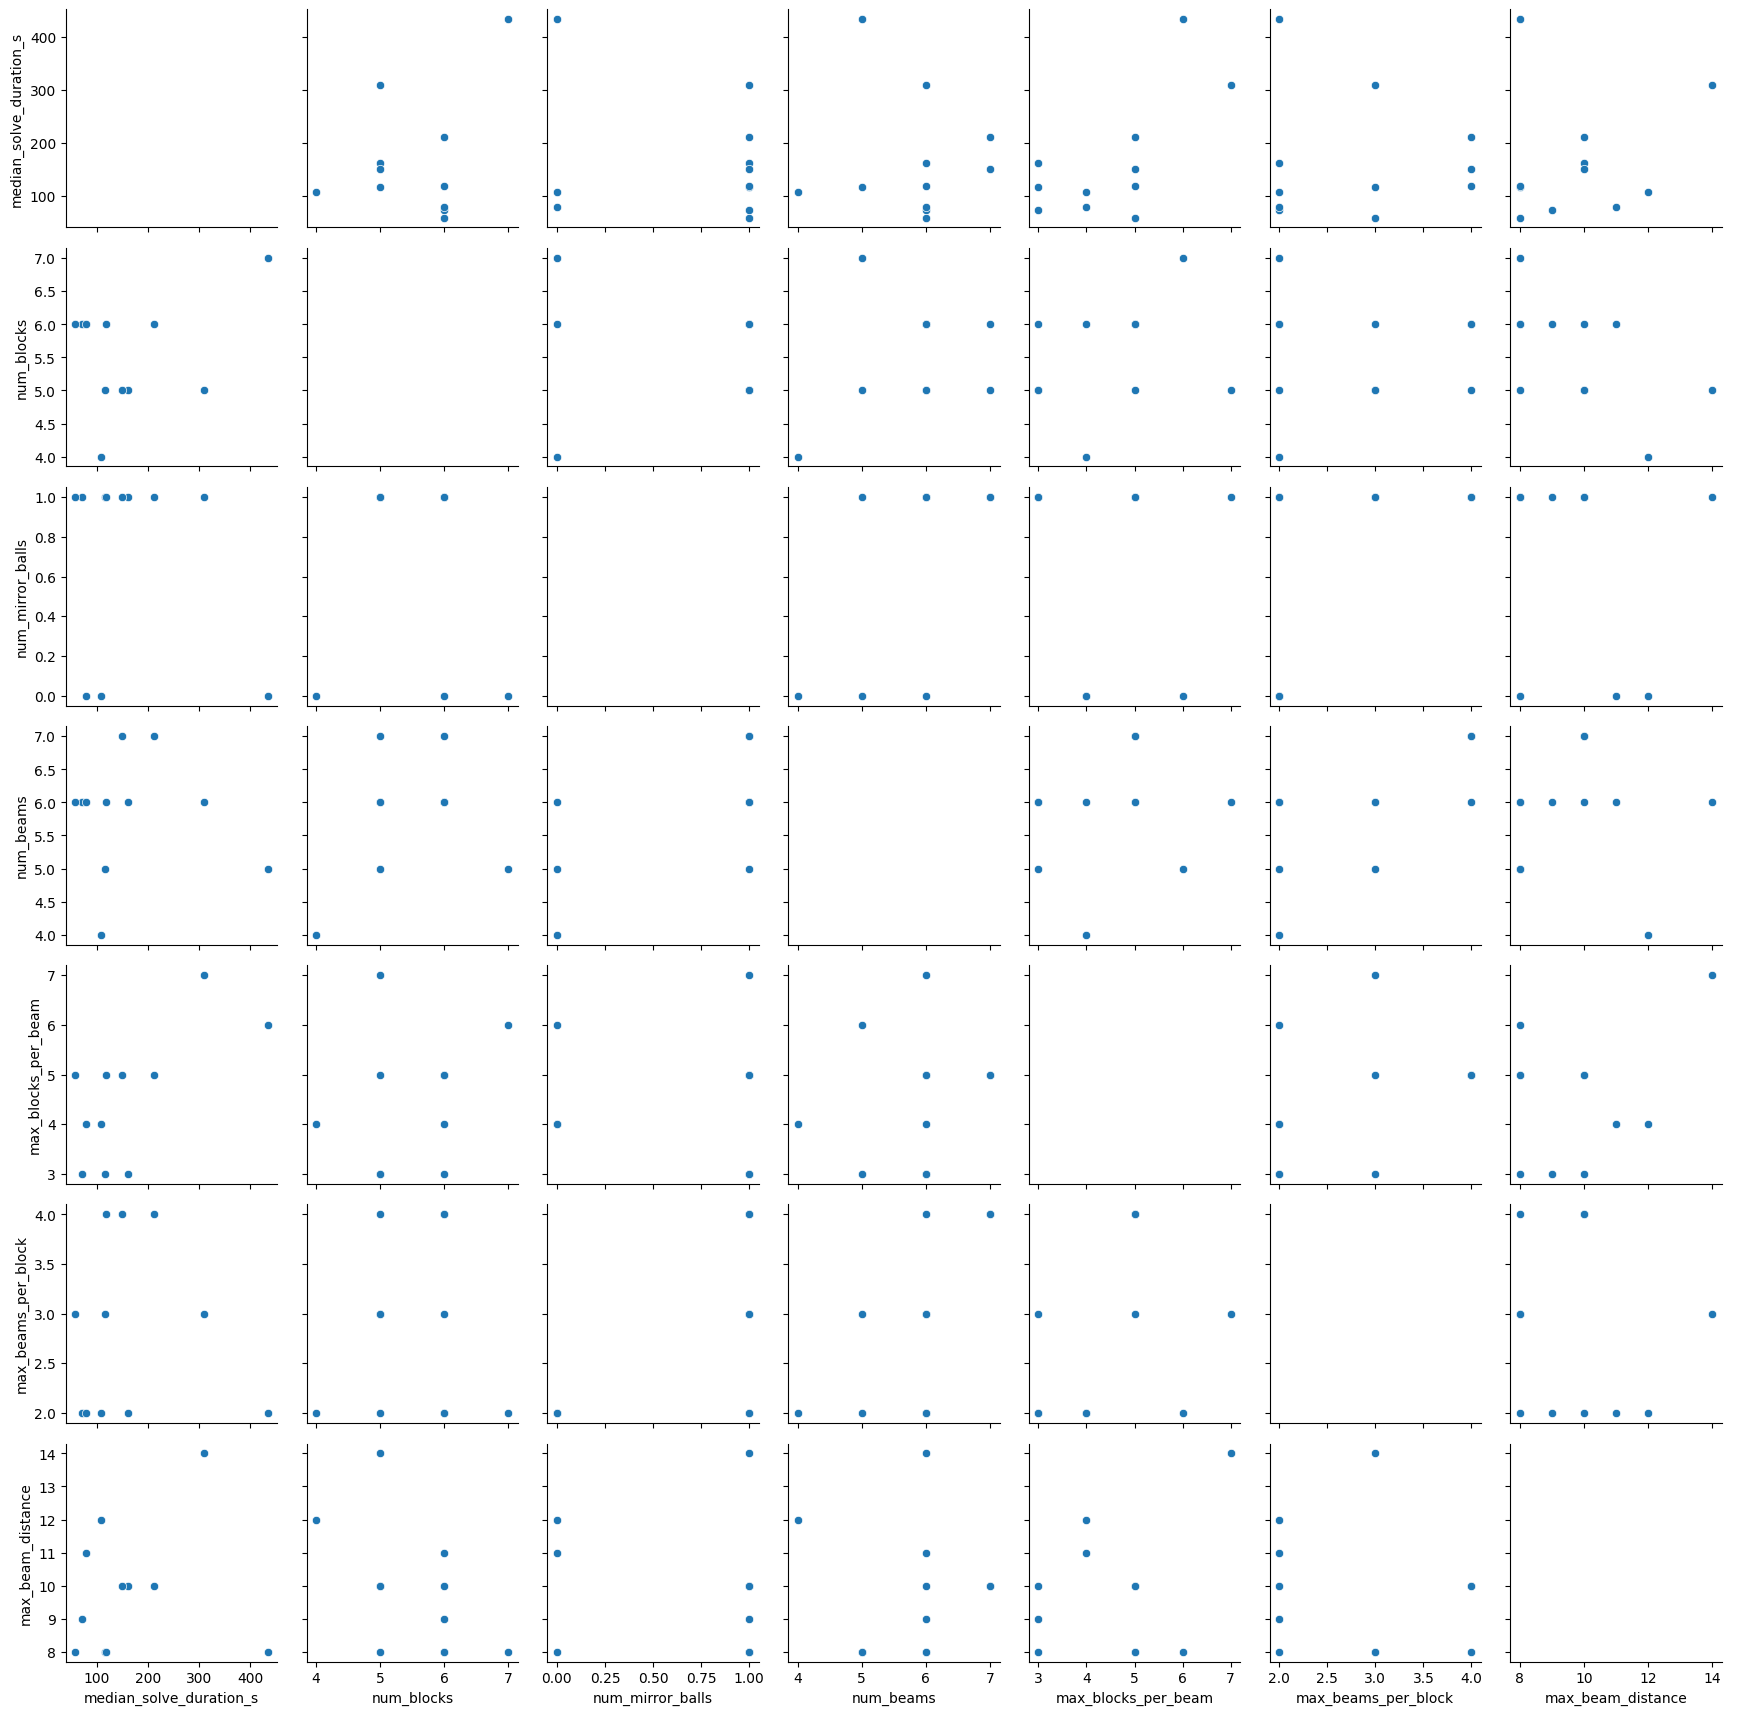

In [16]:
import seaborn as sns
df_correlation = df_all[["median_solve_duration_s", "num_blocks", "num_mirror_balls", "num_beams", "max_blocks_per_beam", "max_beams_per_block", "max_beam_distance"]]

g = sns.PairGrid(df_correlation)
g.map_offdiag(sns.scatterplot)
g.add_legend()

# Baseline model

Let's produce a really simple linear model to predict solve duration. This is meant to be a baseline, and will hopefully help in setting puzzles of appropriate difficultly.

In [17]:
from sklearn.linear_model import LinearRegression
X = df_correlation[["max_blocks_per_beam"]]
y = df_correlation[["median_solve_duration_s"]]
regr = LinearRegression()
regr.fit(X, y)

LinearRegression()

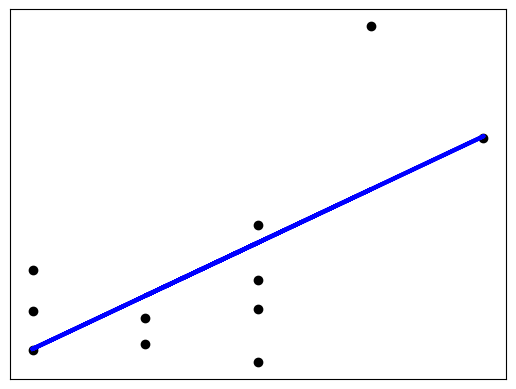

In [18]:
import matplotlib.pyplot as plt
plt.scatter(X, y,  color='black')
plt.plot(X, regr.predict(X), color='blue', linewidth=3)
plt.xticks(())
plt.yticks(())
plt.show()

In [19]:
from joblib import dump
dump(regr, "model.joblib") 

['model.joblib']